<div class="fluid-row" id="section-header">
<center>
    <h1>
        <u>Used Cars Price Prediction</u>
    </h1>
</center>
<div class="fluid-row" id="section-header">
    <h2 class="title toc-ignore">Introduction</h2>
    <p class="lead">In this notebook I will build a multiple regression model that can predict cars price based on multiple features such as mileage, mark, model, model_year, fuel_type and the city, the data I will work with was extracted from a famous ads platform called Avito</a>. The notebook will be presented as follow : 
    </p>
    <ul class="lead">
        <li>Data collection</li>
        <li>Data Preprocessing & Cleansing</li>
        <li>Exploratory data analysis & Visualisation</li>
        <li>Data Modeling</li>
        <li>Evaluting the Model</li>
    </ul>
</div>

## Data collection

In [1]:
# data colelction and preprocessing
from bs4 import BeautifulSoup
import requests
import pandas as pd
import csv
# for data visualisation and statistical analysis
import numpy as np
from sklearn.cross_validation import train_test_split
import seaborn as sns
sns.set_style("white")
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

/Users/sahilarora/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
def get_ads_urls():
    urls_list = []
    # define the basic url to crawl on
    basic_url = "https://www.avito.ma/fr/maroc/voitures-à_vendre?mpr=500000000&o="
    # loop over the paginated urls
    for i in range(1,250):
        # get the page url
        url = basic_url+str(i)
        # get the request response
        r  = requests.get(url)
        data = r.text
        # transform it to bs object
        soup = BeautifulSoup(data, "lxml")
        # loop over page links
        for div in soup.findAll('div', {'class': 'item-img'}):
            a = div.findAll('a')[0]
            urls_list.append(a.get('href'))


    df = pd.DataFrame(data={"url": urls_list})
    df.to_csv("./data/ads_urls.csv", sep=',',index=False)

In [ ]:
# get the ads urls and save them in a file
get_ads_urls()

In [4]:
def scrap_ad_data(ad_url):
    r = requests.get(ad_url)
    data = r.text
    soup = BeautifulSoup(data, "html.parser")
    target_component = soup.findAll("h2",  {"class": ["font-normal", "fs12", "no-margin", "ln22"]})
    # create a list that will hold our component data
    results = []
    for i in target_component:
        results.append(''.join(i.findAll(text=True)).replace('\n',''))
    return results

In [5]:
def write_data_to_csv(data):
    with open("./data/output.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(data)

In [8]:
# read the saved urls file as a dataframe 
urls_data = pd.read_csv("./data/ads_urls.csv")
# create  a list that will hold the final data
final_result = []
i = 1
# loop over the dataframe
for index, row in urls_data.iterrows():
    final_result.append(scrap_ad_data(row['url']))
    # to count how many page we have processed since qe have 35 links per page
    #i += 1
    #if i%100 == 0:
    #    print("page ",i, "done")
print('Scrapping data finished')
# now that we have all the data we can write it in a csv file
write_data_to_csv(final_result)

Scrapping data finished


## Data Preprocessing & Cleansing

In [8]:
# set the column names
colnames=['price', 'year_model', 'mileage', 'fuel_type', 'mark', 'model', 'fiscal_power', 'sector', 'type', 'city'] 
# read the csv file as a dataframe
df = pd.read_csv("output.csv", sep=",", names=colnames, header=None)
# let's get some simple vision on our dataset
df.head()

,price,year_model,mileage,fuel_type,mark,model,fiscal_power,sector,type,city
0,135 000 DH,Année-Modèle:2013,Kilométrage:160 000 - 169 999,Type de carburant:Diesel,Marque:Peugeot,Modèle:508,Puissance fiscale:-,-,"Type:Voitures, Offre",Temara
1,53 000 DH,Année-Modèle:2008,Kilométrage:35 000 - 39 999,Type de carburant:Diesel,Marque:Renault,Modèle:Clio,Puissance fiscale:-,-,"Type:Voitures, Offre",Safi
2,59 000 DH,Année-Modèle:2007,Kilométrage:180 000 - 189 999,Type de carburant:Diesel,Marque:Citroen,Modèle:C3,Puissance fiscale:6 CV,Secteur:oued_fes,"Type:Voitures, Offre",Fès
3,88 000 DH,Année-Modèle:2010,Kilométrage:35 000 - 39 999,Type de carburant:Diesel,Marque:Mercedes-Benz,Modèle:220,Puissance fiscale:-,-,"Type:Voitures, Offre",Nador
4,60 000 DH,Année-Modèle:2009,Kilométrage:130 000 - 139 999,Type de carburant:Essence,Marque:Ford,Modèle:Fiesta,Puissance fiscale:7 CV,Secteur:saies,"Type:Voitures, Offre",Fès


### Starting the Preprocessing

#### Price Columns

<p class="lead">One thing I have noticed is that there are some ads that were published without the price, so the first thing to do is to delete those rows.</p>

In [9]:
# remove thos rows doesn't contain the price value
df = df[df.price.str.contains("DH") == True]
# remove the 'DH' caracters from the price
df.price = df.price.map(lambda x: x.rstrip('DH'))
# remove the space on it
df.price = df.price.str.replace(" ","")
# change it to integer value
df.price = pd.to_numeric(df.price, errors = 'coerce', downcast= 'integer')

#### Year Model

In [10]:
# remove thos rows doesn't contain the year_model value
df = df[df.year_model.str.contains("Année-Modèle") == True]
# remove the 'Année-Modèle:' from the year_model
df.year_model = df.year_model.map(lambda x: x.lstrip('Année-Modèle:').rstrip('ou plus ancien'))
# df.year_model = df.year_model.map(lambda x: x.lstrip('Plus de '))
# remove those lines having the year_model not set
df = df[df.year_model != ' -']
df = df[df.year_model != '']
# change it to integer value
df.year_model = pd.to_numeric(df.year_model, errors = 'coerce', downcast = 'integer')

#### mileage

<p class="lead">Taking mean of the min and max milage of each car </p>

In [ ]:
# remove thos rows doesn't contain the year_model value
df = df[df.mileage.str.contains("Kilométrage") == True]
# remove the 'Kilométrage:' string from the mileage feature 
df.mileage = df.mileage.map(lambda x: x.lstrip('Kilométrage:'))
df.mileage = df.mileage.map(lambda x: x.lstrip('Plus de '))
# remove those lines having the mileage values null or '-'
df = df[df.mileage != '-']
# we have only one value type that is equal to 500 000, all the other ones contain two values
if any(df.mileage != '500 000'):
    # create two columns minim and maxim to calculate the mileage mean
    df['minim'], df['maxim'] = df.mileage.str.split('-', 1).str
    # remove spaces from the maxim & minim values 
    df['maxim'] = df.maxim.str.replace(" ","")
    df['minim'] = df.minim.str.replace(" ","")
    df['maxim'] = df['maxim'].replace(np.nan, 500000)
    # calculate the mean of mileage 
    df.mileage = df.apply(lambda row: (int(row.minim) + int(row.maxim)) / 2, axis=1)
    # now that the mileage is calculated so we do not need the minim and maxim values anymore
    df = df.drop(columns=['minim', 'maxim'])

In [16]:
df=df.drop('minim', axis=1)


In [17]:
df=df.drop('maxim',axis=1)

In [18]:
df.head()

,price,year_model,mileage,fuel_type,mark,model,fiscal_power,sector,type,city
0,135000,2013,164999.5,Type de carburant:Diesel,Marque:Peugeot,Modèle:508,Puissance fiscale:-,-,"Type:Voitures, Offre",Temara
1,53000,2008,37499.5,Type de carburant:Diesel,Marque:Renault,Modèle:Clio,Puissance fiscale:-,-,"Type:Voitures, Offre",Safi
2,59000,2007,184999.5,Type de carburant:Diesel,Marque:Citroen,Modèle:C3,Puissance fiscale:6 CV,Secteur:oued_fes,"Type:Voitures, Offre",Fès
3,88000,2010,37499.5,Type de carburant:Diesel,Marque:Mercedes-Benz,Modèle:220,Puissance fiscale:-,-,"Type:Voitures, Offre",Nador
4,60000,2009,134999.5,Type de carburant:Essence,Marque:Ford,Modèle:Fiesta,Puissance fiscale:7 CV,Secteur:saies,"Type:Voitures, Offre",Fès


#### Fuel type

In [8]:
# remove the 'Type de carburant:' string from the carburant_type feature
df.fuel_type = df.fuel_type.map(lambda x: x.lstrip('Type de carburant:'))

#### Mark & Model

In [9]:
# remove the 'Marque:' string from the mark feature
df['mark'] = df['mark'].map(lambda x: x.replace('Marque:', ''))
df = df[df.mark != '-']
# remove the 'Modèle:' string from model feature 
df['model'] = df['model'].map(lambda x: x.replace('Modèle:', ''))

#### fiscal power

<p class="lead">Filling empty values with the mean.</p>

In [10]:
df.fiscal_power.value_counts()

Puissance fiscale:-                5624
Puissance fiscale:6 CV             1011
Puissance fiscale:8 CV              692
Puissance fiscale:7 CV              495
Puissance fiscale:9 CV              207
Puissance fiscale:11 CV             115
Puissance fiscale:10 CV             109
Puissance fiscale:5 CV              107
Puissance fiscale:12 CV             103
Puissance fiscale:4 CV               22
Puissance fiscale:17 CV              14
Puissance fiscale:13 CV              11
Puissance fiscale:21 CV               8
Puissance fiscale:-                   6
Puissance fiscale:20 CV               5
Puissance fiscale:23 CV               4
Puissance fiscale:Plus de 48 CV       3
Puissance fiscale:14 CV               3
Puissance fiscale:26 CV               2
Puissance fiscale:15 CV               2
Puissance fiscale:29 CV               2
Puissance fiscale:18 CV               2
Puissance fiscale:40 CV               2
Puissance fiscale:28 CV               1
Puissance fiscale:34 CV               1


In [11]:
# remove the 'Puissance fiscale:' from the fiscal_power feature
df.fiscal_power = df.fiscal_power.map(lambda x: x.lstrip('Puissance fiscale:Plus de').rstrip(' CV'))
# replace the - with NaN values and convert them to integer values
df.fiscal_power = df.fiscal_power.str.replace("-","0")
# convert all fiscal_power values to numerical ones 
df.fiscal_power = pd.to_numeric(df.fiscal_power, errors = 'coerce', downcast= 'integer')
# now we need to fill those 0 values with the mean of all fiscal_power columns
df.fiscal_power = df.fiscal_power.map( lambda x : df.fiscal_power.mean() if x == 0 else x )

#### fuel type

In [12]:
# remove those lines having the fuel_type not set
df = df[df.fuel_type != '-']

#### drop unwanted columns

In [13]:
df = df.drop(columns=['sector', 'type'])

## Exploratory data analysis & Visualisation

### price distribution by year_model

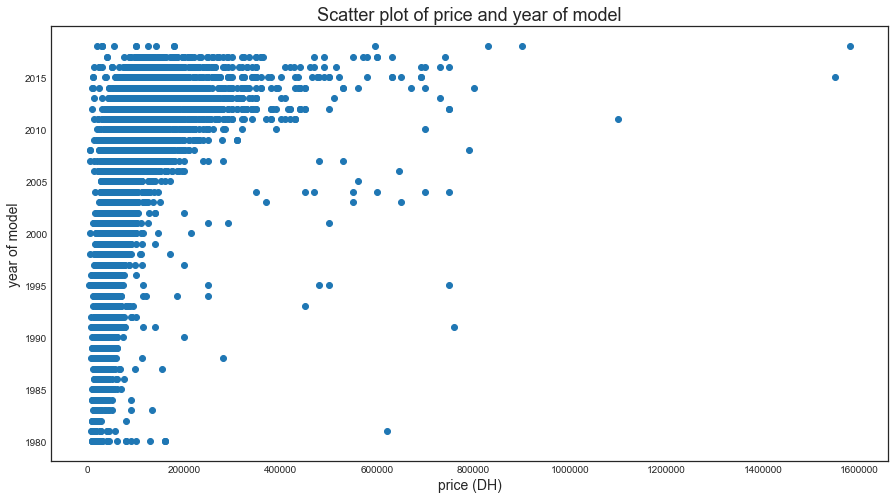

In [60]:
# here we set the figure size to 15x8
plt.figure(figsize=(15, 8))
# plot two values price per year_model
plt.scatter(df.price, df.year_model)
plt.xlabel("price (DH)", fontsize=14)
plt.ylabel("year of model", fontsize=14)
plt.title("Scatter plot of price and year of model",fontsize=18)
plt.show()

### Price distribution by mark

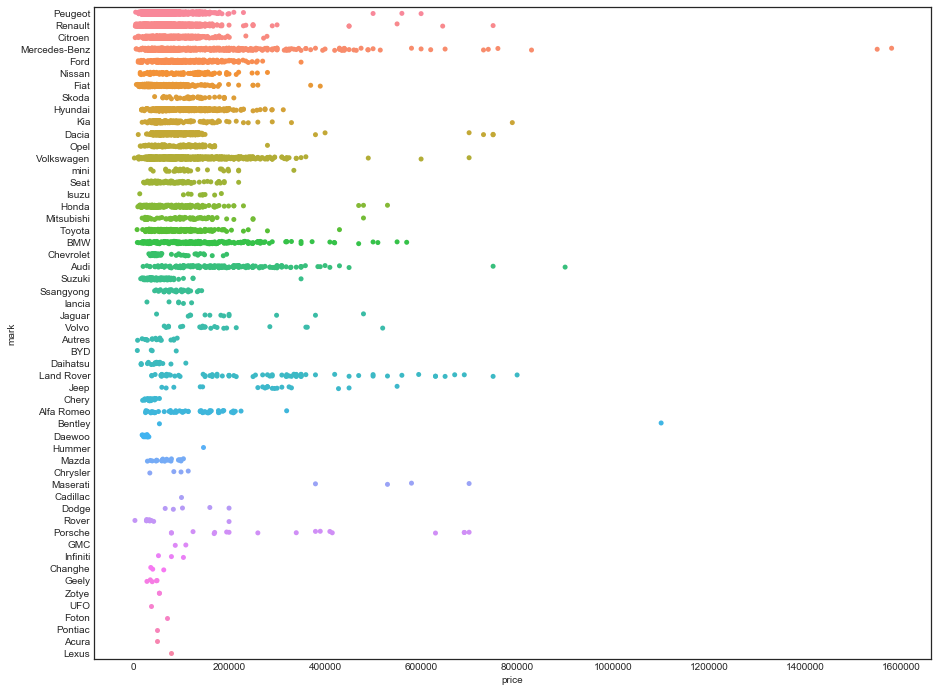

In [61]:
f, ax = plt.subplots(figsize=(15, 12))
sns.stripplot(data = df, x='price', y='mark', jitter=.1)
plt.show()

### price distribution by fiscal_power

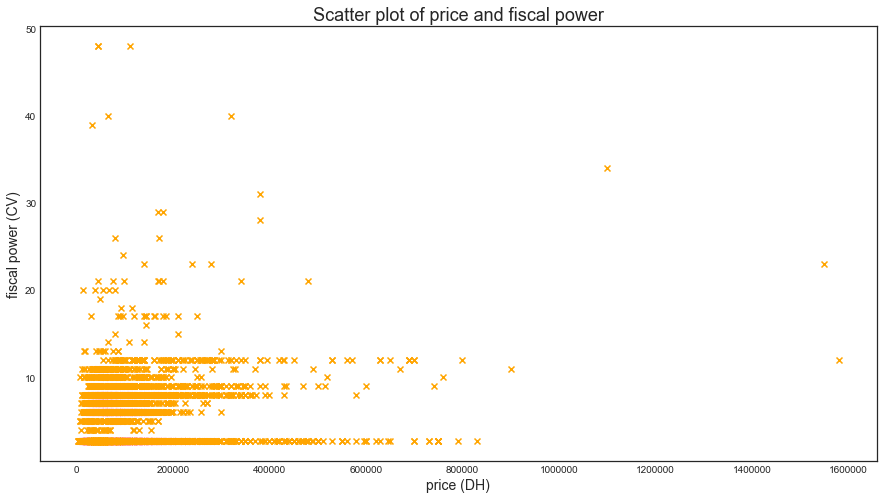

In [62]:
# here we set the figure size to 15x8
plt.figure(figsize=(15, 8))
# plot two values price per year_model
plt.scatter(df.price, df.fiscal_power, c='orange', marker='x')
plt.xlabel("price (DH)", fontsize=14)
plt.ylabel("fiscal power (CV)", fontsize=14)
plt.title("Scatter plot of price and fiscal power",fontsize=18)
plt.show()

### Top 20 Mark Distribution

In [63]:
print('The length of unique marks feature is',len(df.mark.unique()))

The length of unique marks feature is 54


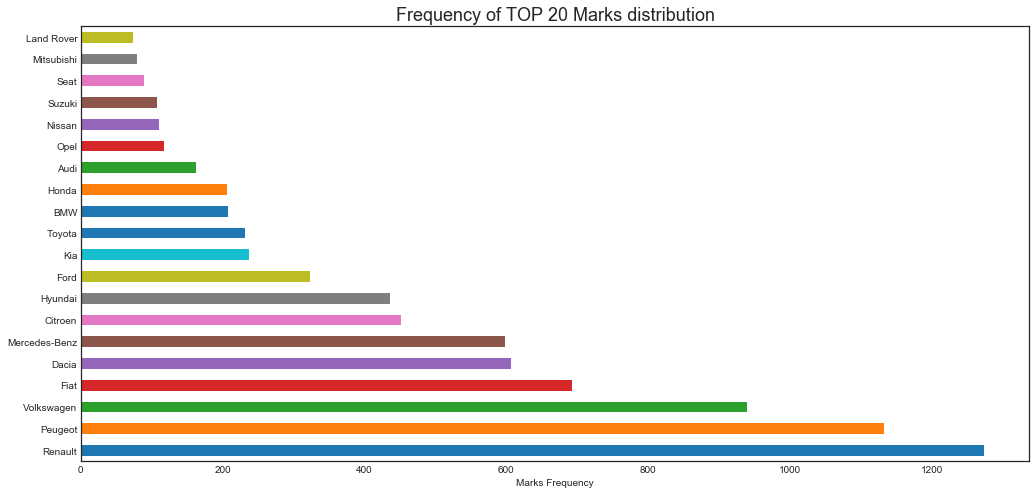

In [64]:
plt.figure(figsize=(17,8))
df.mark.value_counts().nlargest(20).plot(kind='barh')
plt.xlabel('Marks Frequency')
plt.title("Frequency of TOP 20 Marks distribution",fontsize=18)
plt.show()

### Price Distribution by fuel type

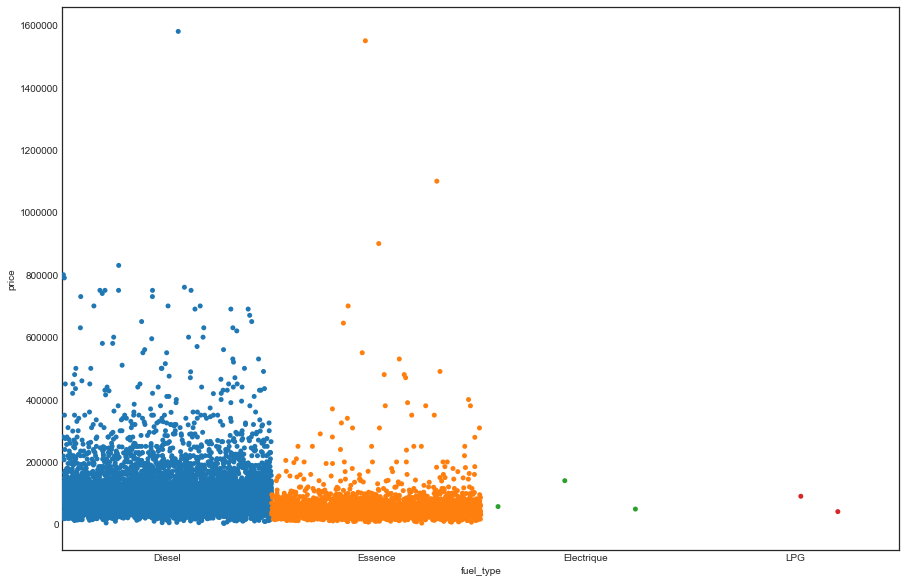

In [65]:
f, ax = plt.subplots(figsize=(15, 10))
sns.stripplot(data = df, x='fuel_type', y='price', jitter=.5)
plt.show()

### Correlation matrix

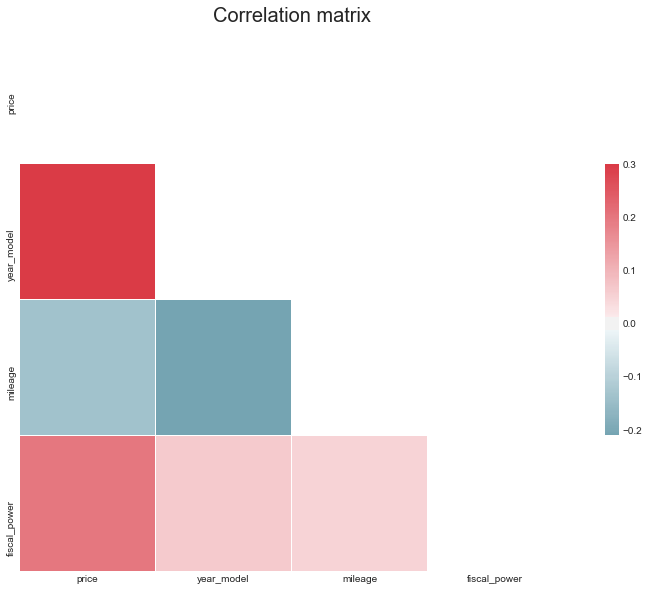

In [69]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))
# Compute the correlation matrix
corr = df.corr()
#print(corr)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation matrix', 
          fontsize = 20)
plt.show()

# Data Modeling 

## KNN Regression

In [14]:
## create a dataframefor testing
data = df[df.price < 400000]

In [15]:
data.head()

,price,year_model,mileage,fuel_type,mark,model,fiscal_power,city
0,135000,2013,164999.5,Diesel,Peugeot,508,2.631837,Temara
1,53000,2008,37499.5,Diesel,Renault,Clio,2.631837,Safi
2,59000,2007,184999.5,Diesel,Citroen,C3,6.000000,Fès
3,88000,2010,37499.5,Diesel,Mercedes-Benz,220,2.631837,Nador
4,60000,2009,134999.5,Essence,Ford,Fiesta,7.000000,Fès


In [16]:
print(len(data))
print(len(df))

8456
8553


### Dealing with Categorical Features

In [17]:
X = data[['year_model', 'mileage', 'fiscal_power', 'fuel_type', 'mark']]
Y = data.price
X = pd.get_dummies(data=X)

In [18]:
X.head()

,year_model,mileage,fiscal_power,fuel_type_Diesel,fuel_type_Electrique,fuel_type_Essence,fuel_type_LPG,mark_Acura,mark_Alfa Romeo,mark_Audi,...,mark_Skoda,mark_Ssangyong,mark_Suzuki,mark_Toyota,mark_UFO,mark_Volkswagen,mark_Volvo,mark_Zotye,mark_lancia,mark_mini
0,2013,164999.5,2.631837,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2008,37499.5,2.631837,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2007,184999.5,6.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2010,37499.5,2.631837,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2009,134999.5,7.000000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data Splitting 

In [19]:
# now we use the train_test_split function already available in sklearn library to split our data set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 42)

In [ ]:
from sklearn import neighbors
# the value of n_neighbors will be changed when we plot the histogram showing the lowest RMSE value
knn = neighbors.KNeighborsRegressor(n_neighbors=6)
knn.fit(X_train, Y_train)

predicted = knn.predict(X_test)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, predicted))
print('RMSE:')
print(rmse)

In [78]:
from sklearn.metrics import r2_score
print('Variance score: %.2f' % r2_score(Y_test, predicted))

Variance score: 0.56


In [79]:
rmse_l = []
num = []
for n in range(2, 16):
    knn = neighbors.KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, Y_train)
    predicted = knn.predict(X_test)
    rmse_l.append(np.sqrt(mean_squared_error(Y_test, predicted)))
    num.append(n)

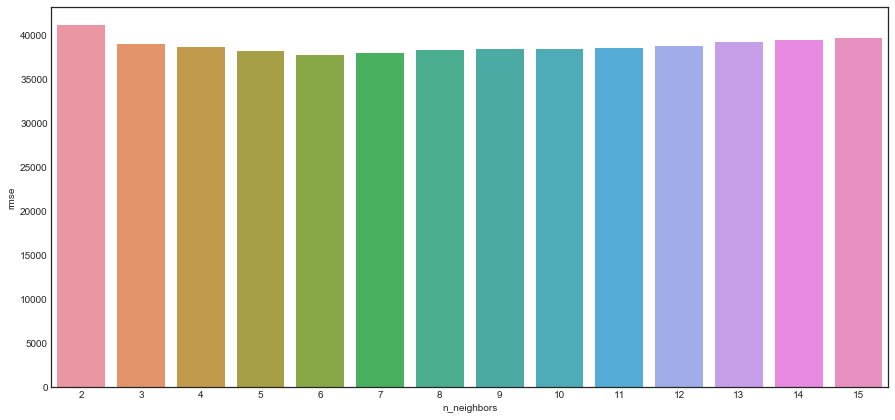

In [80]:
df_plt = pd.DataFrame()
df_plt['rmse'] = rmse_l
df_plt['n_neighbors'] = num
ax = plt.figure(figsize=(15,7))
sns.barplot(data = df_plt, x = 'n_neighbors', y = 'rmse')
plt.show()

<p class="lead">It appears that 6 nearest neighbors is the optimal number of neighbors.</p>

## Descision Tree Regression

In [ ]:
 from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_features='auto')
dtr.fit(X_train, Y_train)
predicted = dtr.predict(X_test)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, predicted))
print('RMSE:')
print(rmse)

In [26]:
print('Variance score: %.2f' % r2_score(Y_test, predicted))

Variance score: 0.63


## Linear Regression 

In [ ]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

predicted = regr.predict(X_test)


from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, predicted))
print('RMSE:')
print(rmse)

In [30]:
print('Variance score: %.2f' % r2_score(Y_test, predicted))

Variance score: 0.62


## Boosting

In [39]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

r_sq = []
deep = []
mean_scores = []

#loss : {‘ls’, ‘lad’, ‘huber’, ‘quantile’}
for n in range(3, 11):
    gbr = GradientBoostingRegressor(loss ='ls', max_depth=n)
    gbr.fit (X, Y)
    deep.append(n)
    r_sq.append(gbr.score(X, Y))
    mean_scores.append(cross_val_score(gbr, X, Y, cv=12).mean())

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

gbr = GradientBoostingRegressor(loss ='ls', max_depth=6)
gbr.fit (X_train, Y_train)
predicted = gbr.predict(X_test)

rmse = np.sqrt(mean_squared_error(Y_test, predicted))
scores = cross_val_score(gbr, X, Y, cv=12)

print('\nCross Validation Scores:')
print(scores)
print('\nMean Score:')
print(scores.mean())
print('\nRMSE:')
print(rmse)

In [87]:
print('Variance score: %.2f' % r2_score(Y_test, predicted))

Variance score: 0.80


## Model Evaluation

<table class="table table-bordered">
    <thead>
      <tr>
        <th>Model</th>
        <th>Variance Score</th>
        <th>RMSE</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>KNN</td>
        <td>0.56</td>
        <td>37709.67</td>
      </tr>
      <tr>
        <td>Multiple Linear Regression</td>
        <td>0.62</td>
        <td>34865.07</td>
      </tr>
      <tr style="color: green">
        <td>Gradient Boosting</td>
        <td>0.80</td>
        <td>25176.16</td>
      </tr>
      <tr>
        <td><b>Decision Tree</b></td>
        <td><b>0.63</b></td>
        <td><b>34551.17</b></td>
      </tr>
    </tbody>
</table>

## Prediction

In [39]:
# user_input = [2010, 124999.5, 6, 'Diesel', 'BMW']
user_input = {'year_model':2006, 'mileage':82499.5, 'fiscal_power':6, 'fuel_type':'Diesel', 'mark':'Dacia'}
def input_to_one_hot(data):
    # initialize the target vector with zero values
    enc_input = np.zeros(61)
    # set the numerical input as they are
    enc_input[0] = data['year_model']
    enc_input[1] = data['mileage']
    enc_input[2] = data['fiscal_power']
    # get the array of marks categories
    marks = df.mark.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'mark_'+data['mark']
    # search for the index in columns name list 
    mark_column_index = X.columns.tolist().index(redefinded_user_input)
    #print(mark_column_index)
    # fullfill the found index with 1
    enc_input[mark_column_index] = 1
    # get the array of fuel type
    fuel_types = df.fuel_type.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'fuel_type_'+data['fuel_type']
    # search for the index in columns name list 
    fuelType_column_index = X.columns.tolist().index(redefinded_user_input)
    # fullfill the found index with 1
    enc_input[fuelType_column_index] = 1
    return enc_input

In [40]:
print(input_to_one_hot(user_input))

[  2.00600000e+03   8.24995000e+04   6.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00

In [41]:
a = input_to_one_hot(user_input)

In [42]:
price_pred = gbr.predict([a])

In [43]:
price_pred[0]

59156.004150951689

### Save the best Model

In [44]:
from sklearn.externals import joblib

joblib.dump(gbr, 'model.pkl')

['model.pkl']

In [45]:
gbr = joblib.load('model.pkl')

In [47]:
print("the best price for this Dacia is",gbr.predict([a])[0])

the best price for this Dacia is 59156.004151
